<a href="https://colab.research.google.com/github/debjyotigorai/StockPricePrediction/blob/main/stockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
path='/content/drive/MyDrive/workspace/StockPricePrediction/NFLX.csv'
data=pd.read_csv(path)

In [4]:
data.shape

(1009, 7)

In [5]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200


In [6]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


In [8]:
print(data.head(5))

         Date        Open        High         Low       Close   Adj Close  \
0  2018-02-05  262.000000  267.899994  250.029999  254.259995  254.259995   
1  2018-02-06  247.699997  266.700012  245.000000  265.720001  265.720001   
2  2018-02-07  266.579987  272.450012  264.329987  264.559998  264.559998   
3  2018-02-08  267.079987  267.619995  250.000000  250.100006  250.100006   
4  2018-02-09  253.850006  255.800003  236.110001  249.470001  249.470001   

     Volume  
0  11896100  
1  12595800  
2   8981500  
3   9306700  
4  16906900  


In [9]:
corr = data.corr(method='pearson')
corr

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998605,0.998508,0.996812,0.996812,-0.415838
High,0.998605,1.000000,0.998203,0.998551,0.998551,-0.400699
Low,0.998508,0.998203,1.000000,0.998544,0.998544,-0.432116
Close,0.996812,0.998551,0.998544,1.000000,1.000000,-0.413362
Adj Close,0.996812,0.998551,0.998544,1.000000,1.000000,-0.413362
Volume,-0.415838,-0.400699,-0.432116,-0.413362,-0.413362,1.000000


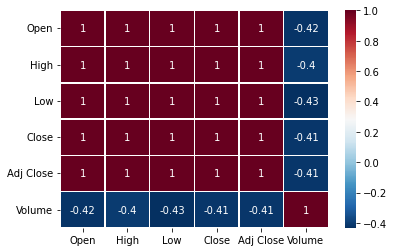

In [10]:
import seaborn as sb
sb.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns,
 cmap='RdBu_r', annot=True, linewidth=0.5)

In [11]:
#prepare dataset to work with
data['Date'] = pd.to_datetime(data.Date, format='%Y-%m-%d')
nflx_df=data[['Date','High','Open','Low','Close']]
nflx_df.head(10)

,Date,High,Open,Low,Close
0,2018-02-05,267.899994,262.000000,250.029999,254.259995
1,2018-02-06,266.700012,247.699997,245.000000,265.720001
2,2018-02-07,272.450012,266.579987,264.329987,264.559998
3,2018-02-08,267.619995,267.079987,250.000000,250.100006
4,2018-02-09,255.800003,253.850006,236.110001,249.470001
5,2018-02-12,259.149994,252.139999,249.000000,257.950012
6,2018-02-13,261.410004,257.290009,254.699997,258.269989
7,2018-02-14,269.880005,260.470001,260.329987,266.000000
8,2018-02-15,280.500000,270.029999,267.630005,280.269989
9,2018-02-16,281.959991,278.730011,275.690002,278.519989


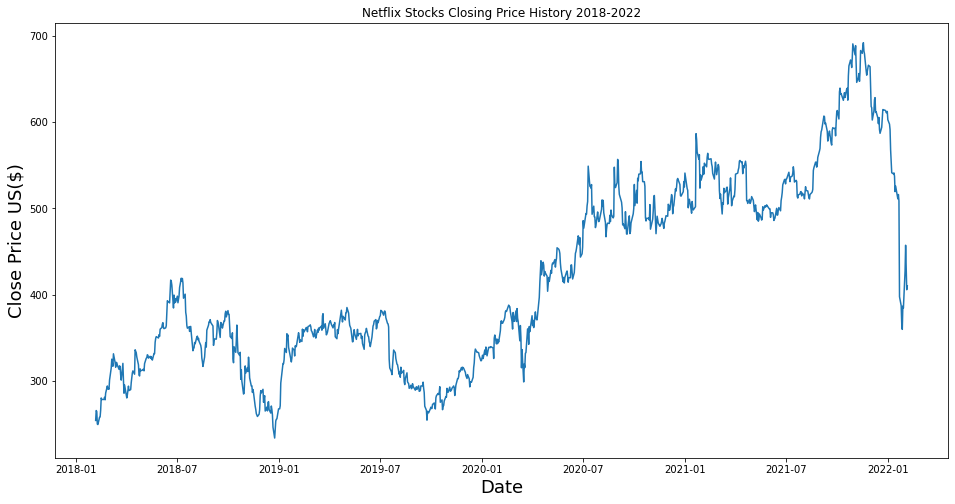

In [12]:
plt.figure(figsize=(16,8))
plt.title('Netflix Stocks Closing Price History 2018-2022')
plt.plot(nflx_df['Date'],nflx_df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price US($)',fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

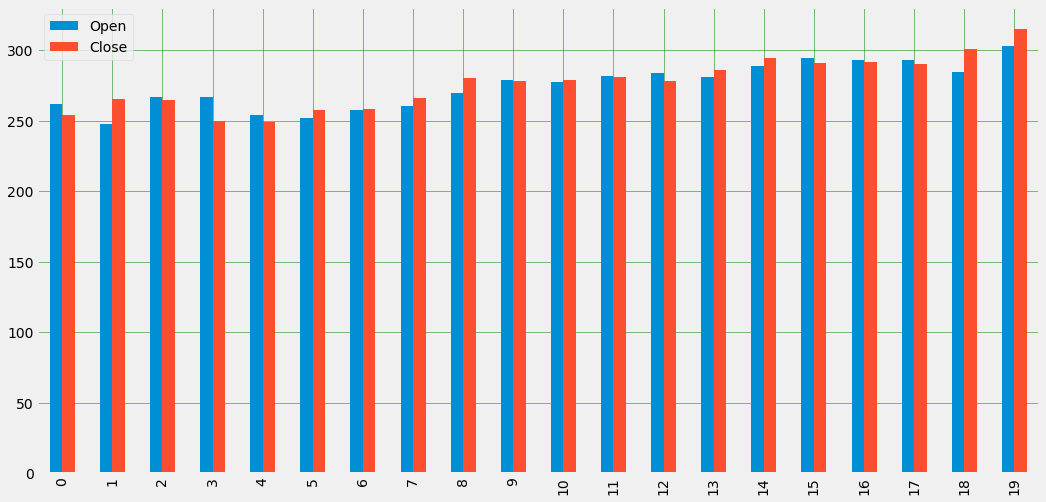

In [13]:
#Plot Open vs Close
nflx_df[['Open','Close']].head(20).plot(kind='bar',figsize=(16,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

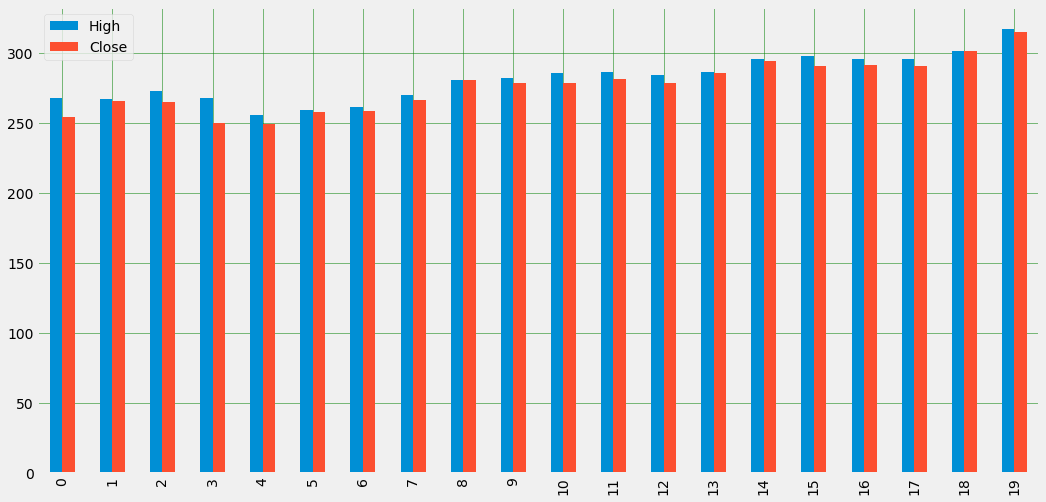

In [14]:
#Plot High vs Close
nflx_df[['High','Close']].head(20).plot(kind='bar',figsize=(16,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

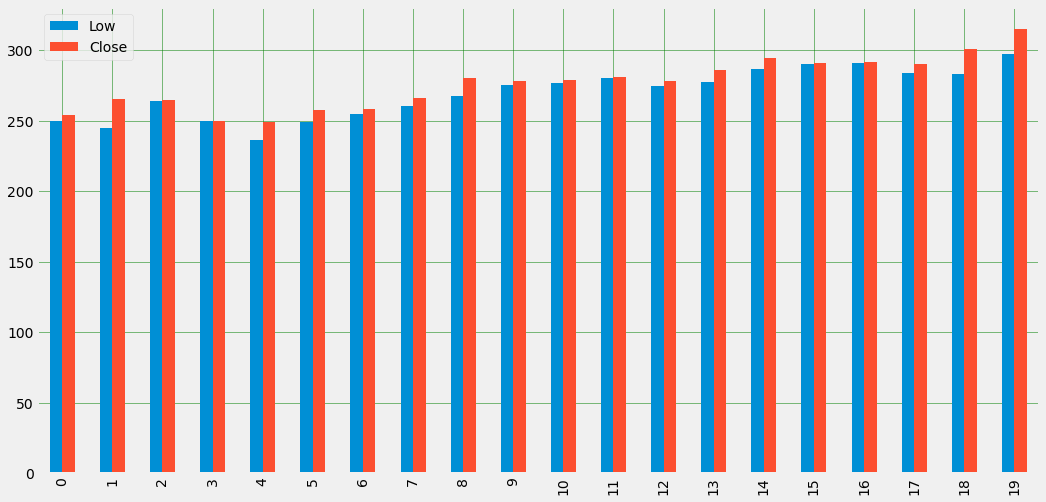

In [15]:
#Plot Low vs Close
nflx_df[['Low','Close']].head(20).plot(kind='bar',figsize=(16,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [16]:
nflx_df['Day']=data['Date'].dt.day
nflx_df['Month']=data['Date'].dt.month
nflx_df['Year']=data['Date'].dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
nfx_df=nflx_df[['Day','Month','Year','High','Open','Low','Close']]
nfx_df.head(10)

,Day,Month,Year,High,Open,Low,Close
0,5,2,2018,267.899994,262.000000,250.029999,254.259995
1,6,2,2018,266.700012,247.699997,245.000000,265.720001
2,7,2,2018,272.450012,266.579987,264.329987,264.559998
3,8,2,2018,267.619995,267.079987,250.000000,250.100006
4,9,2,2018,255.800003,253.850006,236.110001,249.470001
5,12,2,2018,259.149994,252.139999,249.000000,257.950012
6,13,2,2018,261.410004,257.290009,254.699997,258.269989
7,14,2,2018,269.880005,260.470001,260.329987,266.000000
8,15,2,2018,280.500000,270.029999,267.630005,280.269989
9,16,2,2018,281.959991,278.730011,275.690002,278.519989


In [18]:
X = nfx_df.iloc[:,nfx_df.columns !='Close']
Y= nfx_df.iloc[:, 5]
print(X.shape) #output: (2093, 6)
print(Y.shape) #output: (2093,)

(1009, 6)
(1009,)


In [19]:
x_train,x_test,y_train,y_test= train_test_split(X,Y,test_size=.25)

In [20]:
print(x_train.shape) #output: (1569, 6)
print(x_test.shape) #output: (524, 6) 
print(y_train.shape) #output: (1569,)
print(y_test.shape) #output: (524,)
#y_test to be evaluated with y_pred for Diff models

(756, 6)
(253, 6)
(756,)
(253,)


**Linear Regression Model Training and Testing**

In [21]:
from sklearn.linear_model import LinearRegression
lr_model=LinearRegression()
lr_model.fit(x_train,y_train)

LinearRegression()

In [22]:
y_pred=lr_model.predict(x_test)

Linear Model Cross-Validation

In [23]:
from sklearn import model_selection
from sklearn.model_selection import KFold
KFold = model_selection.KFold(n_splits=20, random_state=None)
results_KFold = model_selection.cross_val_score(lr_model, x_test, y_test.astype('int'), cv=KFold)
print("Accuracy: ", results_KFold.mean()*100)

Accuracy:  99.99910035100021


Plot Actual vs Predicted Value

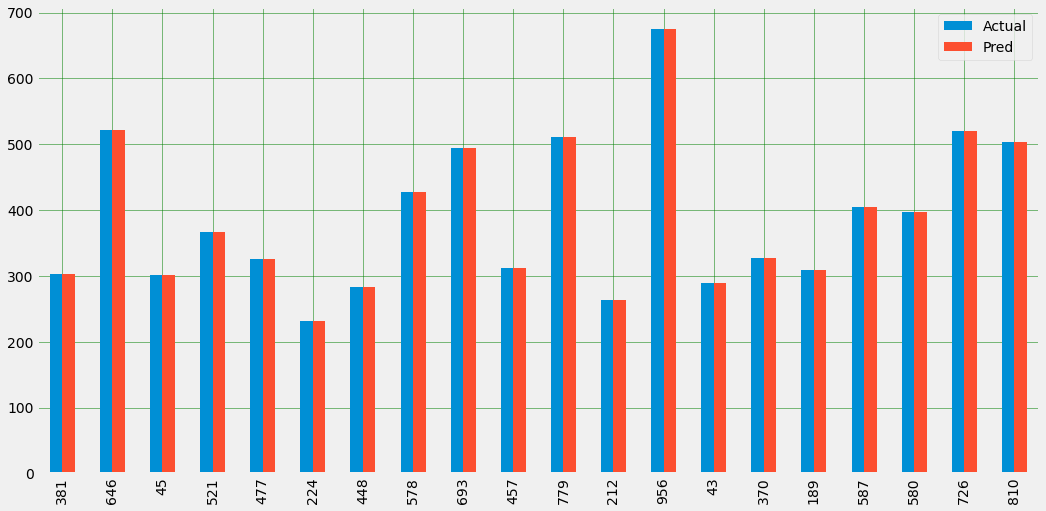

In [24]:
plot_df=pd.DataFrame({'Actual':y_test,'Pred':y_pred})
plot_df.head(20).plot(kind='bar',figsize=(16,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

**KNN Model Training and Testing**

In [25]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor=KNeighborsRegressor(n_neighbors = 4)
knn_model=knn_regressor.fit(x_train,y_train)
y_knn_pred=knn_model.predict(x_test)

KNN Cross-Validation

In [26]:
knn_kfold = model_selection.KFold(n_splits=20, random_state=None)
results_kfold = model_selection.cross_val_score(knn_model, x_test, y_test.astype('int'), cv=knn_kfold)
print('Accuracy: ', results_kfold.mean()*100)

Accuracy:  99.76705328707578


Plot Actual vs Predicted Value

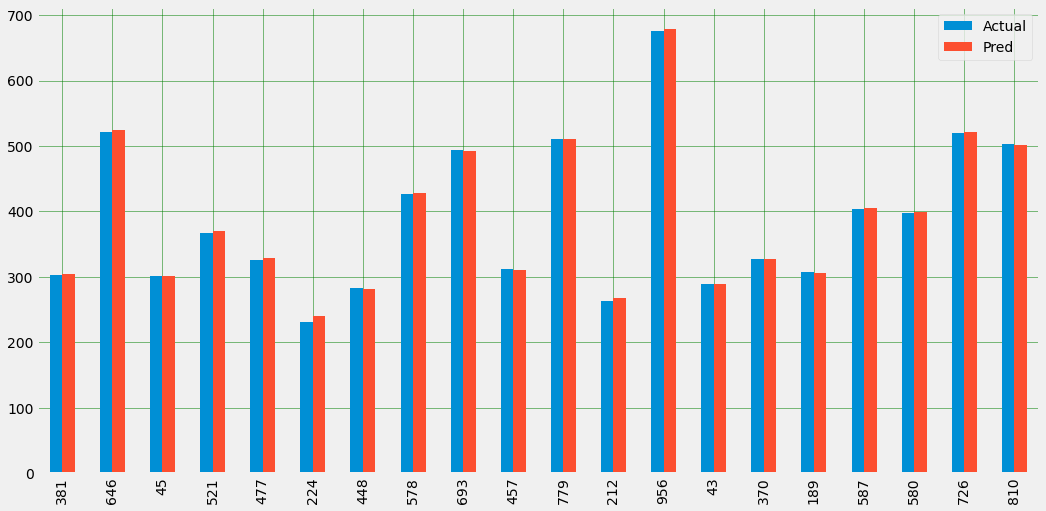

In [27]:
plot_knn_df=pd.DataFrame({'Actual':y_test,'Pred':y_knn_pred})
plot_knn_df.head(20).plot(kind='bar',figsize=(16,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

**SVM Model Training and Testing**

In [28]:
from sklearn.svm import SVR
svm_regressor = SVR(kernel='linear')
svm_model=svm_regressor.fit(x_train,y_train)
y_svm_pred=svm_model.predict(x_test)

Plot Actual vs Predicted Value

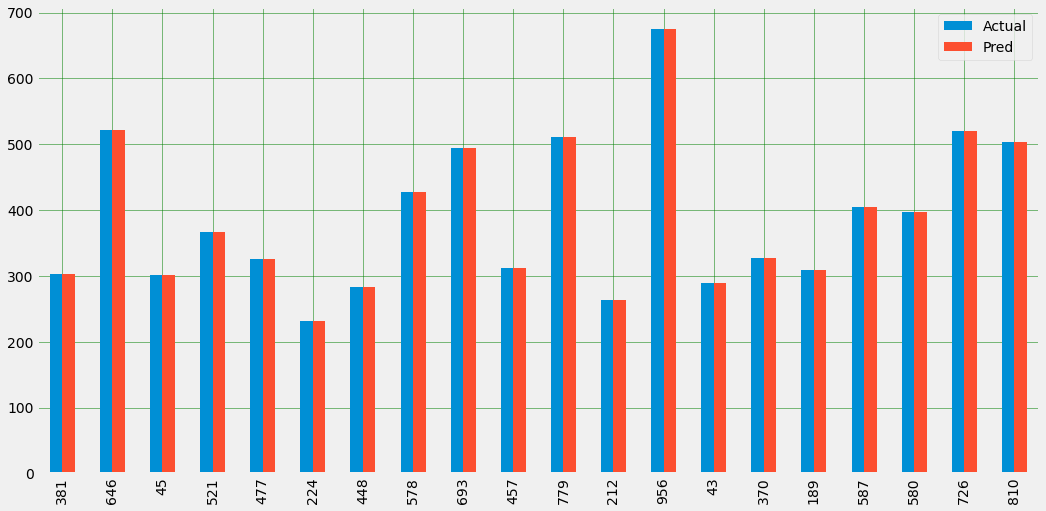

In [29]:
plot_svm_df=pd.DataFrame({'Actual':y_test,'Pred':y_svm_pred})
plot_svm_df.head(20).plot(kind='bar',figsize=(16,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()